In [1]:
!ls ../Data/data_set_phase1/

profiles.csv	test_queries.csv  train_plans.csv
test_plans.csv	train_clicks.csv  train_queries.csv


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import warnings
import time
from collections import Counter
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

main_path = r'../Data/data_set_phase1/'

# Train data

## Train queries

### EDA

In [3]:
train_queries_df = pd.read_csv(main_path+'train_queries.csv')
# train_queries_df = train_queries_df_copy.copy()

In [4]:
train_queries_df.head()

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"
3,559931,202427.0,2018-11-23 14:54:11,"116.27,39.88","116.39,39.90"
4,2819352,172251.0,2018-10-30 11:48:41,"116.34,39.96","116.37,39.86"


* sid: session ID [会话id]
* pid: profile ID [用户id？]
* req_time: request time [查询请求时间]
* o: original point [出发地坐标]
* d: destination point [目的地坐标]

In [5]:
# check null
train_queries_df.isnull().sum()

sid              0
pid         163979
req_time         0
o                0
d                0
dtype: int64

In [6]:
163979/train_queries_df.shape[0]

0.327958

In [7]:
train_queries_df.nunique()/train_queries_df.shape[0]

sid         1.000000
pid         0.092382
req_time    0.928422
o           0.010920
d           0.009846
dtype: float64

In [8]:
train_queries_df['o'].value_counts()[:10]

116.37,39.86    5993
116.32,39.89    5930
116.42,39.90    5819
116.41,39.91    5616
116.37,39.91    5246
116.40,39.91    5156
116.39,39.90    4366
116.35,39.94    3674
116.41,39.90    3048
116.39,39.91    3048
Name: o, dtype: int64

In [9]:
train_queries_df['d'].value_counts()[:10]

116.32,39.89    16503
116.37,39.86    13124
116.42,39.90    11256
116.39,39.90     7575
116.39,39.91     7571
116.41,39.91     6348
116.37,39.91     5665
116.45,39.93     5357
116.27,40.00     4222
116.40,39.93     3782
Name: d, dtype: int64

### 小结
* pid缺失严重
    * 讨论如何填补这个缺失值
* sid为唯一值
* 同一个出发地坐标或者目的坐标出现的次数多
* 后期特征工程中需要看看req_time的时间分布情况，如：早晚高峰，节假日或者周末，周五等等。
    * 处理方案是将时间戳划分出星期（标签型 or One-hot？）、小时（标签型 or One-hot？）、是否节假日（binary）等特征
* 数据来自北京市用户出行的用户行为，因此在特征工程的时候是否需要考虑出发或者目的坐标的真实地理位置（市中心、商业集中地、景点等等），以此来加入堵车、人流量过高的真实现象。

## Train plans

### EDA

In [10]:
train_plans_df = pd.read_csv(main_path+'train_plans.csv')
# train_plans_df = train_plans_df_copy.copy()

In [11]:
train_plans_df.head()

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."
3,1616170,2018-10-03 14:42:40,"[{""distance"": 11450, ""price"": 400, ""eta"": 2801..."
4,351369,2018-10-05 19:52:37,"[{""distance"": 18495, ""price"": 600, ""eta"": 4271..."


* sid: session ID [会话id]
* plan_time: timestamp [计划生成的时间？or 预计出行的具体时间？]
* plans: list of route plans [计划列表]
    * distance: the estimated route distance in meters [估计出行距离（米）]
    * price: the estimated price in RMB cent [估计价格（人民币）]
    * eta: the estimated time of arrival (ETA) in seconds [估计出行时间（秒）]
    * mode: the transport mode [出行方式]

In [12]:
train_plans_df.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [13]:
train_plans_df.nunique()/train_plans_df.shape[0]

sid          1.000000
plan_time    0.927448
plans        0.996964
dtype: float64

### 小结
* 数据无缺失
* 数据重复数量也不高
* 需要根据sid结合quries表继续探索req_time和plan_time的关系
* 时间处理过程中是否加入出行过程中的时间跨度，比如下午16点出行不是晚高峰，但是结合ETA（估计出行时间的特征），可能会在途中遇到晚高峰的情况
    * 解决方案可以在plan_time这个特征上加上ETA，计算出到达目的地的具体时间，再做特征工程。前提是弄清楚req_time和plan_time之间的关系
* plans得再unstack成新的表，统计每个会话里面的最大（最小、平均）价格、最长（最小、平均）出行时间、出行方式出现次数等等，具体得讨论。

## Train clicks
这个应该是label

In [14]:
train_clicks_df = pd.read_csv(main_path+'train_clicks.csv')
# train_clicks_df = train_clicks_df_copy.copy()

### EDA

In [15]:
train_clicks_df.head()

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2
3,2022975,2018-10-14 12:28:11,9
4,988425,2018-11-12 16:47:30,7


**A click record indicates the user feedback of different recommendations. i.e., a user may click on specific routes displayed to him/her for details.**
* sid: session ID [会话时间]
* click_time: a timestamp [点击时间戳]
* click_mode: the clicked transport mode in the display list [用户选择的出行方式]

In [16]:
train_clicks_df.isnull().sum()

sid           0
click_time    0
click_mode    0
dtype: int64

In [17]:
train_clicks_df.nunique()/train_clicks_df.shape[0]

sid           1.000000
click_time    0.931097
click_mode    0.000024
dtype: float64

In [18]:
mode_df = pd.DataFrame(train_clicks_df.click_mode.value_counts())
mode_df['mode'] = mode_df.index
mode_df.columns = ['Frequency', 'Mode']
mode_df

,Frequency,Mode
2,136491,2
7,78209,7
1,70369,1
9,48864,9
5,47480,5
3,24626,3
10,14882,10
4,12606,4
6,11863,6
11,6089,11


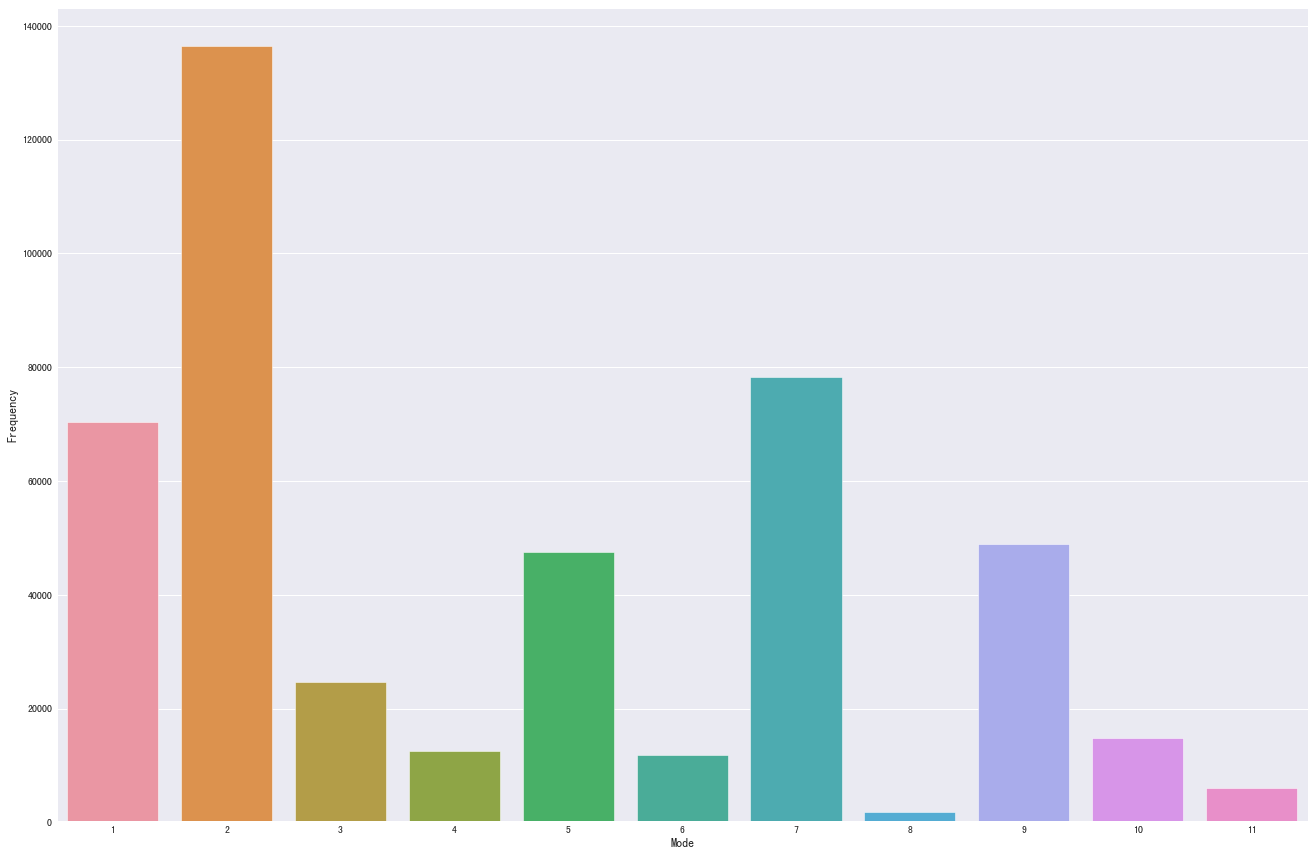

In [19]:
train_clicks_df.click_mode.value_counts()
f, ax = plt.subplots(figsize=(20, 15))
g = sns.barplot(x='Mode', y='Frequency', data=mode_df, ax=ax)

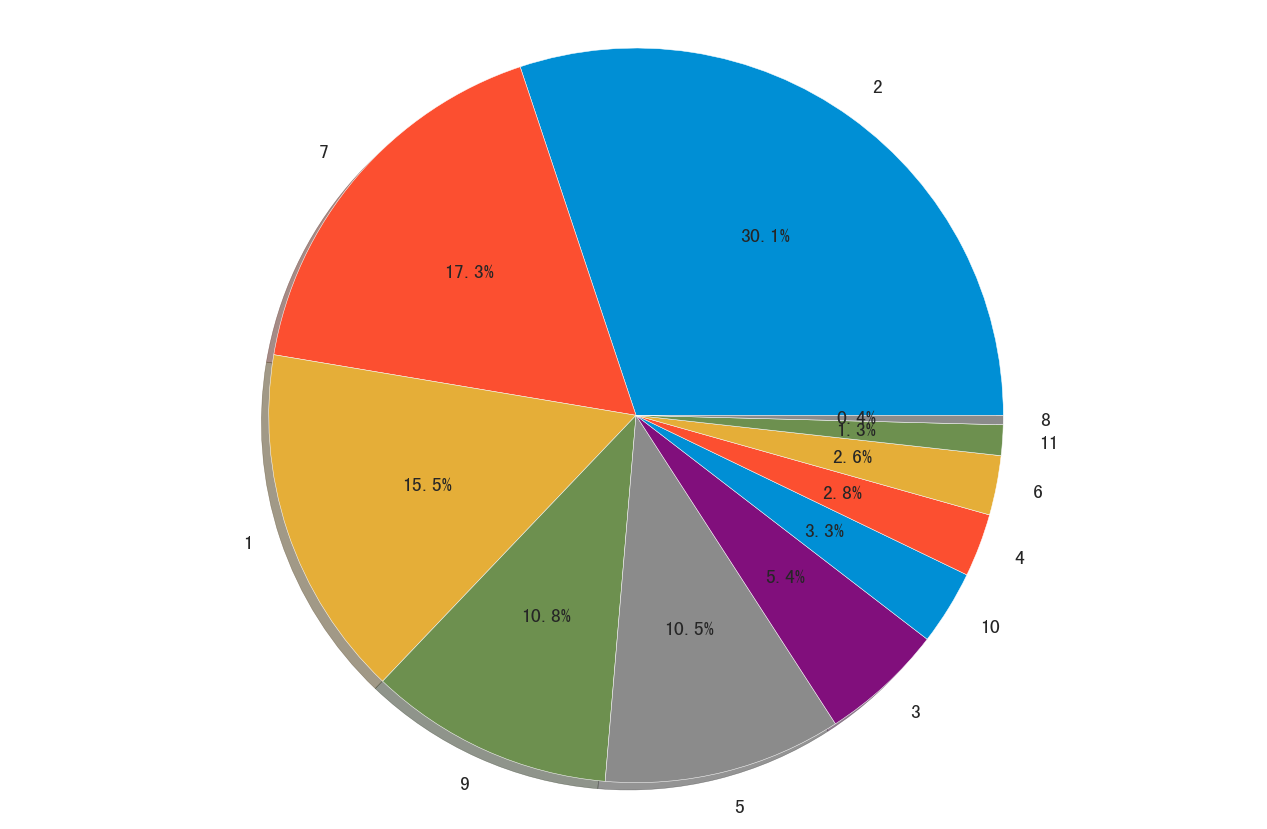

In [20]:
# Pie chart if labels
mpl.rcParams['font.size'] = 20
f1, ax1 = plt.subplots(figsize=(20, 15))
ax1.pie(mode_df['Frequency'].values,
        labels=mode_df['Mode'].values, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

### 小结
* label不平衡
    * 后面得想办法处理（加权采样、组合label、模型加权输出等等）

In [21]:
print('train qureies shape:', train_queries_df.shape)
print('train plans shape:', train_plans_df.shape)
print('train clicks shape:', train_clicks_df.shape)

train qureies shape: (500000, 5)
train plans shape: (491054, 3)
train clicks shape: (453336, 3)


* 并不是所有的queries都会有对应的plans

# Test data

## Test queries

In [22]:
test_queries_df = pd.read_csv(main_path+'test_queries.csv')

In [23]:
test_queries_df.head()

,sid,pid,req_time,o,d
0,1126541,178395.0,2018-12-05 14:51:43,"116.41,39.92","116.46,39.95"
1,453685,179178.0,2018-12-01 12:50:33,"116.39,39.90","116.41,39.91"
2,2066073,184748.0,2018-12-07 10:17:35,"116.37,39.71","116.31,39.89"
3,452746,162795.0,2018-12-01 07:52:44,"116.33,39.97","116.31,39.98"
4,1431672,116384.0,2018-12-06 10:36:30,"116.51,39.68","116.51,39.68"


In [24]:
# check null
test_queries_df.isnull().sum()

sid             0
pid         31447
req_time        0
o               0
d               0
dtype: int64

In [25]:
print('缺失占比：',31447/test_queries_df.shape[0])

缺失占比： 0.3332732783653744


In [26]:
test_queries_df.nunique()/test_queries_df.shape[0]

sid         1.000000
pid         0.140942
req_time    0.891880
o           0.034517
d           0.030564
dtype: float64

### 小结
* 和train_queries情况基本一致

## test plan

In [27]:
test_plans_df = pd.read_csv(main_path+'test_plans.csv')

In [28]:
test_plans_df.head()

,sid,plan_time,plans
0,1112456,2018-12-05 17:39:47,"[{""distance"": 465, ""price"": """", ""eta"": 418, ""t..."
1,1413458,2018-12-06 17:49:17,"[{""distance"": 28846, ""price"": 600, ""eta"": 4779..."
2,1243160,2018-12-02 14:50:25,"[{""distance"": 24646, ""price"": 600, ""eta"": 3513..."
3,2040494,2018-12-07 09:23:45,"[{""distance"": 32235, ""price"": 600, ""eta"": 4072..."
4,1448779,2018-12-06 18:24:46,"[{""distance"": 13502, ""price"": 400, ""eta"": 3195..."


In [29]:
test_plans_df.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [30]:
test_plans_df.nunique()/test_plans_df.shape[0]

sid          1.000000
plan_time    0.890473
plans        0.995593
dtype: float64

### 小结
* 同train_plans

# profiles

In [31]:
profiles_df = pd.read_csv(main_path+'profiles.csv')

In [32]:
profiles_df.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,115511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,129719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63090 entries, 0 to 63089
Data columns (total 67 columns):
pid    63090 non-null int64
p0     63090 non-null float64
p1     63090 non-null float64
p2     63090 non-null float64
p3     63090 non-null float64
p4     63090 non-null float64
p5     63090 non-null float64
p6     63090 non-null float64
p7     63090 non-null float64
p8     63090 non-null float64
p9     63090 non-null float64
p10    63090 non-null float64
p11    63090 non-null float64
p12    63090 non-null float64
p13    63090 non-null float64
p14    63090 non-null float64
p15    63090 non-null float64
p16    63090 non-null float64
p17    63090 non-null float64
p18    63090 non-null float64
p19    63090 non-null float64
p20    63090 non-null float64
p21    63090 non-null float64
p22    63090 non-null float64
p23    63090 non-null float64
p24    63090 non-null float64
p25    63090 non-null float64
p26    63090 non-null float64
p27    63090 non-null float64
p28    63090 non-null f

* 不存在缺失的情况
* pid的是唯一的;
* p0-p65都是二元的;

In [34]:
print('test qureies shape:', test_queries_df.shape)
print('test plans shape:', test_plans_df.shape)
print('profiles shape:', profiles_df.shape)

test qureies shape: (94358, 5)
test plans shape: (92571, 3)
profiles shape: (63090, 67)


* test_plans和test_queries数据不对等，和train数据情况一致